<a href="https://colab.research.google.com/github/alimoorreza/cs195-fall24-notes/blob/main/cs195_segment_anything_SAM_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS195: Day14

### CS195: Computer Vision, Fall 2024

Monday, October 21st, 2024

📆 [Course Schedule](https://analytics.drake.edu/~reza/teaching/cs195_fall24/cs195_schedule.html) | 📜 [Syllabus](https://analytics.drake.edu/~reza/teaching/cs195_fall24/cs195_syllabus_sp24.pdf)


# Automatically generating object masks with [Segment Anything (SAM) version#1](https://segment-anything.com/)

## Environment Set-up

Make sure you select your __Runtime__ mode to __'T4 GPU'__
It should look as follows:
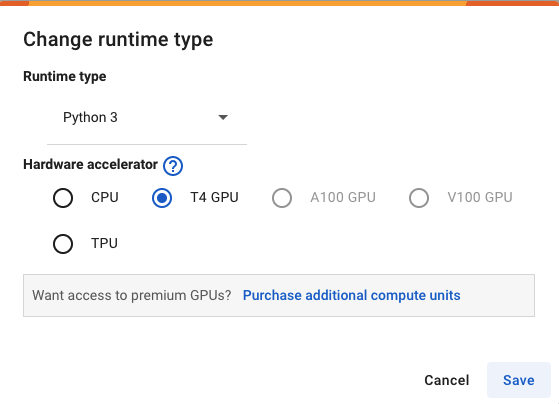

In [ ]:
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://analytics.drake.edu/~reza/teaching/cs195_fall24/datasets/Crocodile_27.png

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-n36a6jcw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-n36a6jcw
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=206bddf2551d7cc292c3e7f5e78caea866e2b5197b932254ff2fc88e6338fe0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-po9z3jwi/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
--2024-10-20 22:54:39--  https://analytics.drake.edu/~reza/teaching/cs195_fall24/datasets/Crocodile_27.png
Resolving analytics.drake.edu (analytics.drake.edu)... 198.7.223.92
Connecting

## Set-up

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
import os
import pickle
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type     = "vit_h"

device         = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)


# To run automatic mask generation, provide a SAM model to the SamAutomaticMaskGenerator class.
# Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.
mask_generator_1  = SamAutomaticMaskGenerator(sam)

# There are several tunable parameters in automatic mask generation that control how densely points are
# sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation
# can be automatically run on crops of the image to get improved performance on smaller objects, and
# post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)


/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


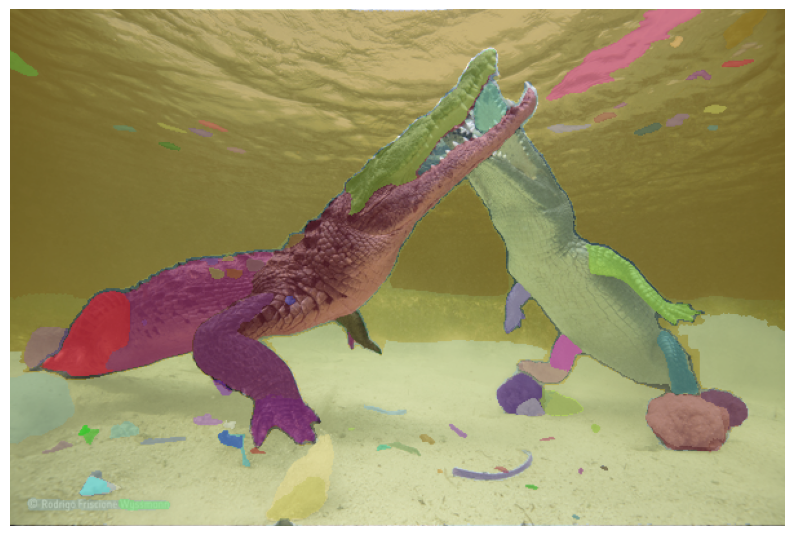

In [ ]:
root_dir            = "/content/images/"
is_display_enabled  = True

'''
file_mask_params 	  = open(dest_root_dir + "mask_params_for_SAM.txt", "w")
sam_mask_params     = "points_per_side=32 \n" + \
                      "pred_iou_thresh=0.86 \n" + \
                      "stability_score_thresh=0.92 \n" + \
                      "crop_n_layers=1 \n" + \
                      "crop_n_points_downscale_factor=2 \n" + \
                      "min_mask_region_area=100,  # Requires open-cv to run post-processing \n"
file_mask_params.write(sam_mask_params)
file_mask_params.close()
'''

cur_image = 'Crocodile_27.png'
#cur_image   = 'gridline.png'

image       = cv2.imread(root_dir + cur_image)
image       = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks2      = mask_generator_2.generate(image)

if is_display_enabled == True:
  plt.figure(figsize=(10,10))
  plt.imshow(image)
  show_anns(masks2)
  plt.axis('off')
  plt.show()


# ---- save the mask ----
# make a directory for each animal
cur_animal    = cur_image.split("/")[0]
dest_dir 	    = root_dir + "/"

# save the masks + image as pickle file
f1      = open(dest_dir + cur_image[0:-4] + '.pkl', 'wb')
my_dict = {'image': image, 'masks': masks2}
pickle.dump(my_dict, f1)
f1.close()


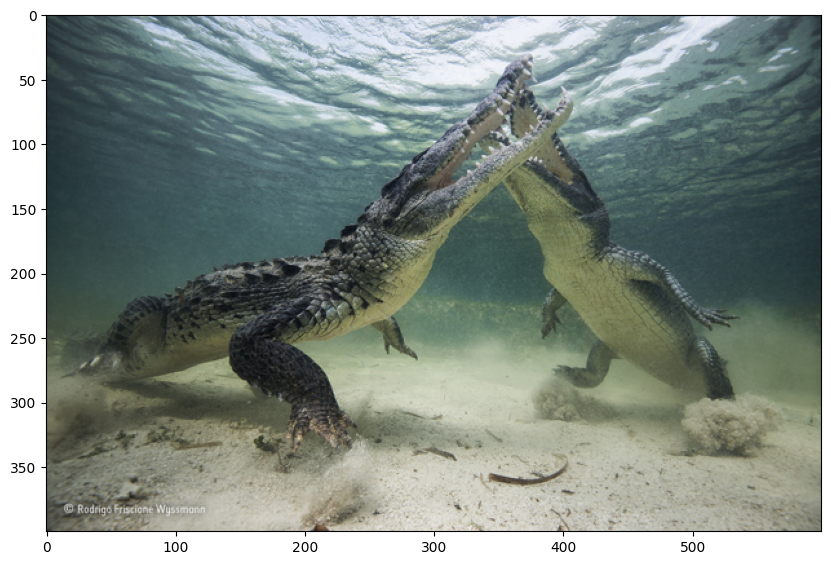

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(image)

## Example image to generate and show different masks

91
(400, 600)


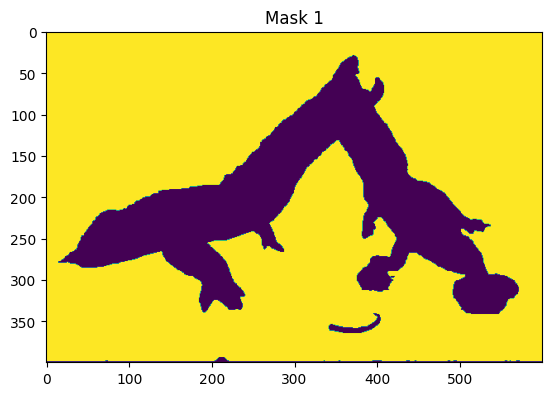

In [ ]:
sorted_anns = sorted(masks2, key=(lambda x: x['area']), reverse=True)
print(len(sorted_anns))
cur_ann = sorted_anns[0]
#print(cur_ann.keys()) # dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
print(cur_ann['segmentation'].shape)
plt.imshow(cur_ann['segmentation'])
plt.title('Mask 1')
plt.show()

(400, 600)


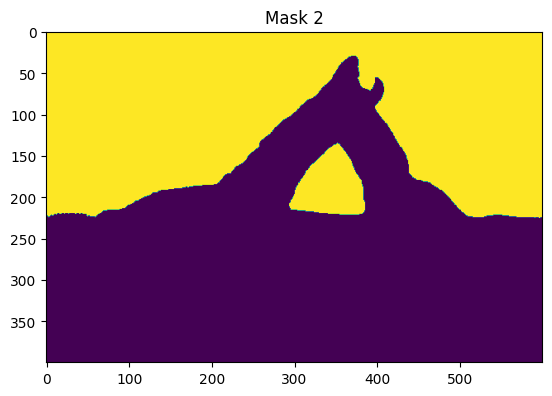

In [ ]:
cur_ann = sorted_anns[1]
#print(cur_ann.keys()) # dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
print(cur_ann['segmentation'].shape)
plt.imshow(cur_ann['segmentation'])
plt.title('Mask 2')
plt.show()

(400, 600)


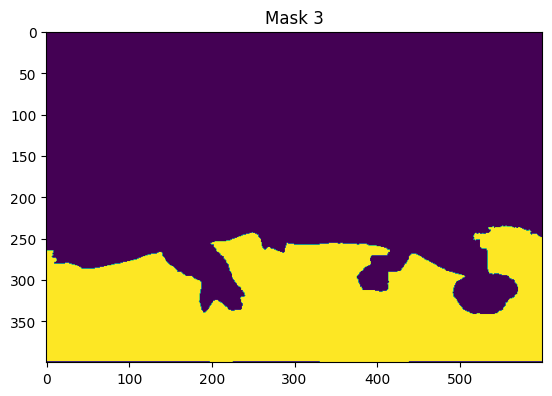

In [ ]:
cur_ann = sorted_anns[2]
#print(cur_ann.keys()) # dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
print(cur_ann['segmentation'].shape)
plt.imshow(cur_ann['segmentation'])
plt.title('Mask 3')
plt.show()

(400, 600)


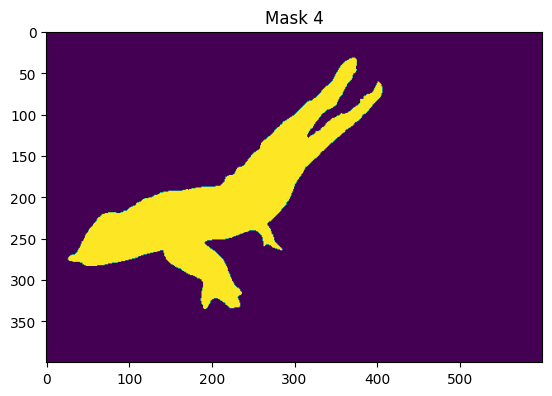

In [ ]:
cur_ann = sorted_anns[3]
#print(cur_ann.keys()) # dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
print(cur_ann['segmentation'].shape)
plt.imshow(cur_ann['segmentation'])
plt.title('Mask 4')
plt.show()

(400, 600)


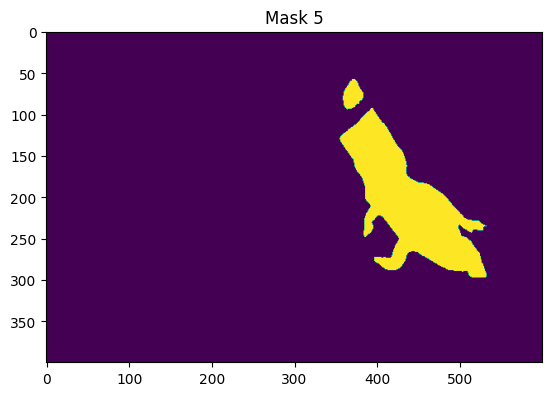

In [ ]:
cur_ann = sorted_anns[4]
#print(cur_ann.keys()) # dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
print(cur_ann['segmentation'].shape)
plt.imshow(cur_ann['segmentation'])
plt.title('Mask 5')
plt.show()

(400, 600)


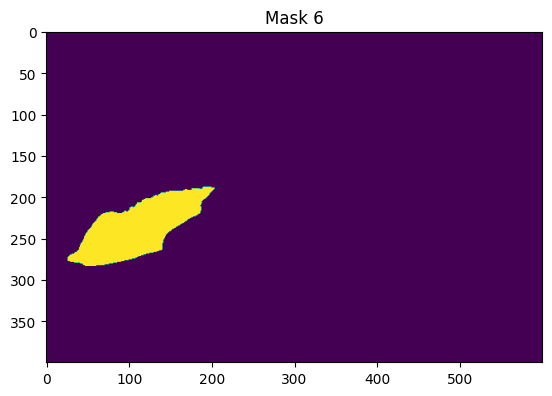

In [ ]:
cur_ann = sorted_anns[5]
#print(cur_ann.keys()) # dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
print(cur_ann['segmentation'].shape)
plt.imshow(cur_ann['segmentation'])
plt.title('Mask 6')
plt.show()

(400, 600)


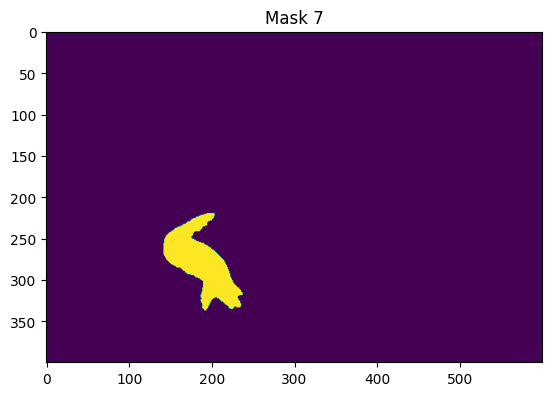

In [ ]:
cur_ann = sorted_anns[6]
#print(cur_ann.keys()) # dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
print(cur_ann['segmentation'].shape)
plt.imshow(cur_ann['segmentation'])
plt.title('Mask 7')
plt.show()

(400, 600)


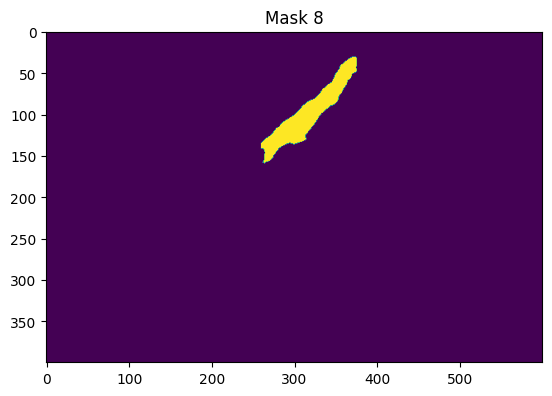

In [ ]:
cur_ann = sorted_anns[7]
#print(cur_ann.keys()) # dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
print(cur_ann['segmentation'].shape)
plt.imshow(cur_ann['segmentation'])
plt.title('Mask 8')
plt.show()

#**Group task#1**
> ### **Task 1: Run Vision Foundation Model Segment Anything (SAM) on a random image of your choice to test its segmentation ability**

In [ ]:
# your code
# ...
# ...
# ...

> ### **Task 2: Summarize your observations and discuss them with your group members.**

>> Observe different masks and discuss it with your table-mates.



>> How many segmentation masks are needed to cover approximately 95% or more of the images?

